#Semana 7: Validación y determinación de hiperparámetros

## Repasando la semana anterior:

La semana anterior trabajamos con modelos polinomiales, y lo usamos como ejemplo para entrar en el tema del sobreajuste (*overfitting*). Al aumentar el grado del polinomio, el modelo comenzaba a aprender "de memoria" los datos del entrenamiento, y se volvía malo para generalizar a datos nuevos no vistos:

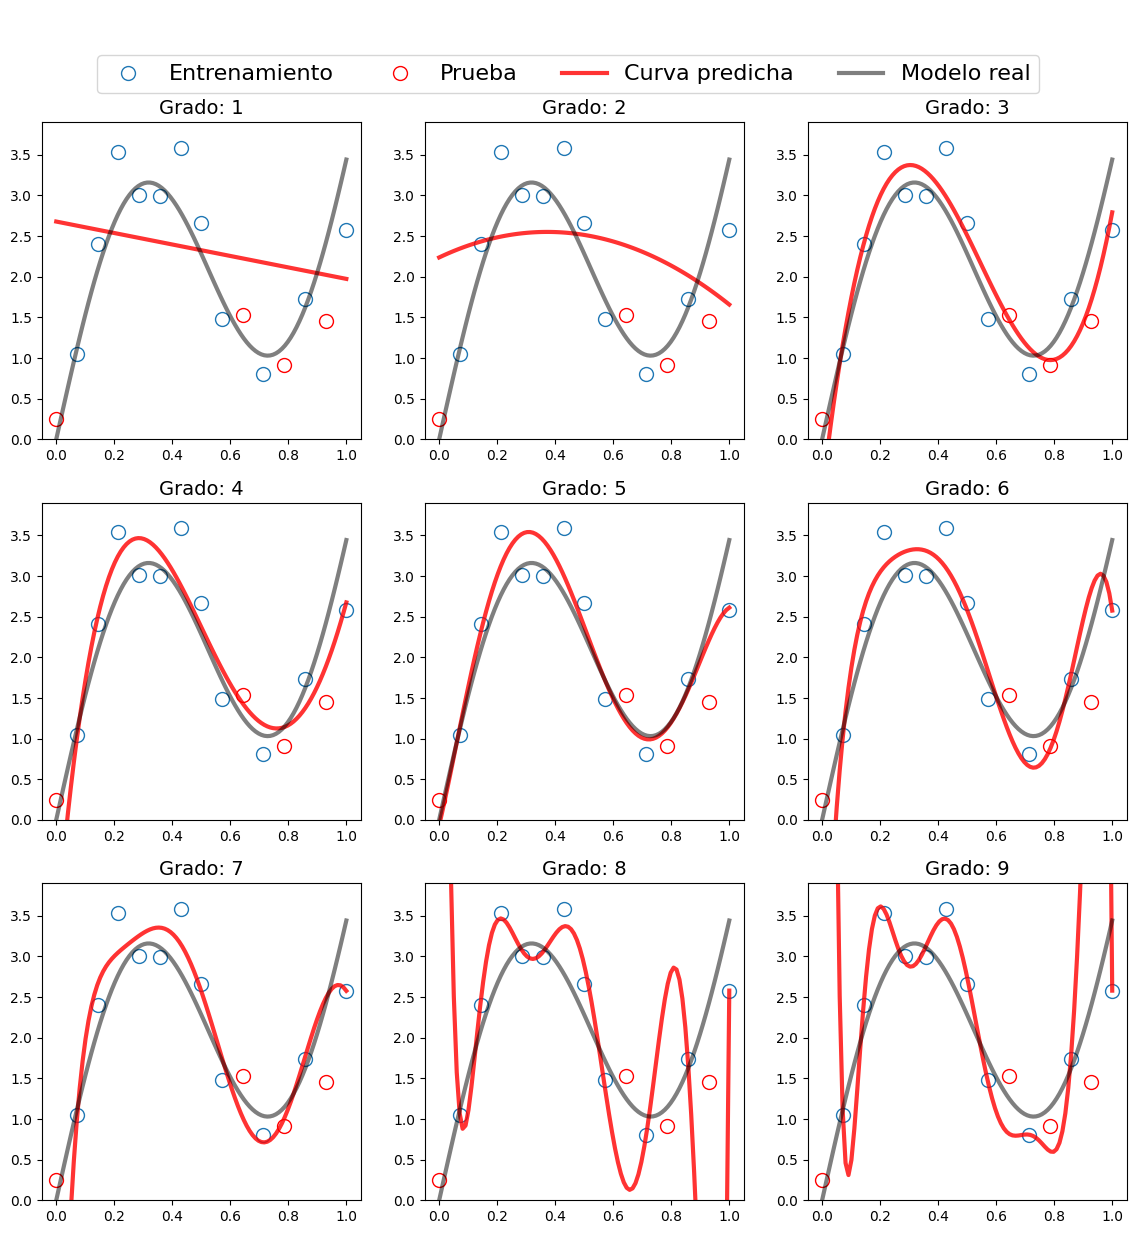

Esto podíamos cuantificarlo mirando el error cuadrático medio en los conjuntos de entrenamiento y testeo:

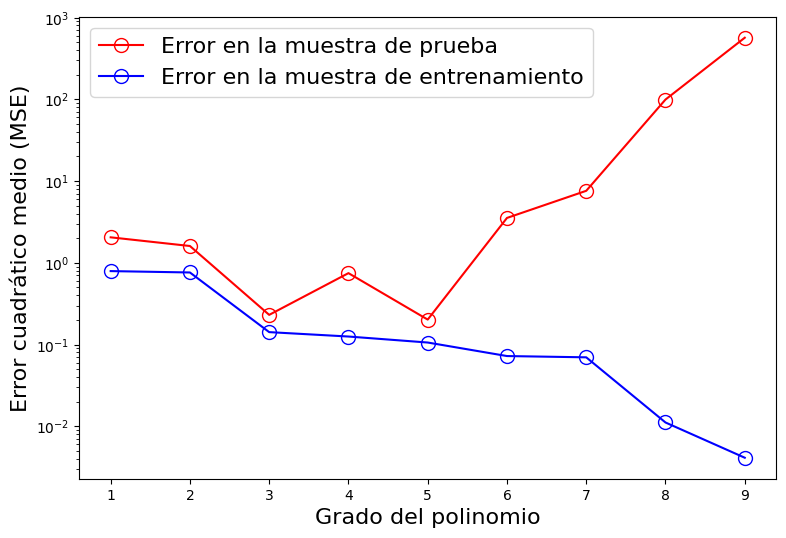

También vimos algunos métodos de regularización, que buscaban evitar el sobreajuste penalizando el entrenamiento si los parámetros del modelo se hacían muy grandes. En particular, vimos el método de Ridge, para el cual teníamos que especificar un nuevo hiperparámetro, lambda (Λ), que cuantificaba esa penalización.

La pregunta que nos quedaba sin responder era entonces: ¿Cómo hacemos para elegir qué grado de polinomio y qué valores de lambda (los hiperparámetros) usar?

## Parámetros e hiperparámetros

En los modelos que vimos hasta ahora, aparecieron dos tipos de parámetros:

*   **Parámetros:** estos son determinados durante el ajuste o entrenamiento del modelo. Son ejemplo de esto los ω de los modelos lineales, la pendiente y la ordenada al origen en el caso del ajuste a una recta, etc.
*   **Hiperparámetros:** estos deben ser elegidos antes de entrenar, ya sea siguiendo algún criterio y haciendo algún tipo de exploración sobre los datos. Son ejemplos de esto el "k" (número de clústers) en el método de K-Means, el grado M del polinomio en los ajustes con polinomios, o el λ en los métodos con regularización.

La pregunta que nos hacemos hoy es precisamente cómo determinar los hiperparámetros óptimos de un modelo. Para ello, siguiendo un poco lo discutido la semana pasada, vamos a incursionar en el método de *validación cruzada*.




## El problema de hoy: ventas de propiedades en Villa Urquiza

Antes de arrancar, hagamos las importaciones comunes


In [ ]:
# Importaciones comunes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Hoy vamos a volver a trabajar con el dataset de Properati. Les damos dos opciones: o cargar el dataset entero y filtrarlo (si ya lo tienen a disposición), o descargar una versión ya reducida (mucho más liviana).

**a)** Versión con el dataset entero:

(Con la función `pandas.read_csv()` pueden leer directamente el archivo comprimido, si ya lo tienen descomprimido, cambien en la siguiente celda la extensión `.zip` a `.csv`)

In [ ]:
import os

## Conectar Drive a Colab
from google.colab import drive
drive.mount('/content/drive')

# cambio al directorio donde están los datos
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/')

# Cargar todo el archivo de Properati en un DataFrame
df_casas = pd.read_csv('properati_arg_SPA.zip')

# Filtro por provincia
provincia = 'Capital Federal'
df_casas = df_casas[df_casas.l2==provincia]
# Filtro por barrio
barrio = 'Villa Urquiza'
df_casas = df_casas[df_casas.l3==barrio]

#df_casas.info()

**b)** Versión con el dataset reducido, que pueden descargar de [acá](https://drive.google.com/file/d/1jTI1MRLe6JSuNSORZxP6ODrxTqoM1iBJ/view?usp=sharing):

In [ ]:
import os

## Conectar Drive a Colab
from google.colab import drive
drive.mount('/content/drive')

# cambio al directorio donde están los datos
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/')

# Cargar el archivo CSV en un DataFrame
df_casas = pd.read_csv('properati_urquiza.csv')

#df_casas.info()

Ahora vamos a hacer un pequeño filtrado de los datos. Si bien vimos que la exploración de los datos y su preprocesamiento es una parte muy importante del proceso, no nos vamos a meter aquí con eso.

In [ ]:
# Limpiado
df_casas = df_casas[(df_casas.moneda=='USD') & (df_casas['tipo_operac'] == 'Venta')]

# Elijo columnas que voy a conservar:
# 'habitaciones', 'dormitorios', 'baños', 'sup_total', 'sup_cubierta', 'precio'
df_casas = df_casas.dropna(subset=['habitaciones', 'precio', 'sup_total','sup_cubierta'])

# filtro valores irreales, outliers, etc.
df_casas = df_casas[(df_casas['sup_total'] < 500) & (df_casas['habitaciones'] < 8) &
                    (df_casas['sup_cubierta'] < 400)]

Hagamos una breve exploración de los datos:

In [ ]:
df_casas.head()

array([[<Axes: xlabel='habitaciones', ylabel='habitaciones'>,
        <Axes: xlabel='precio', ylabel='habitaciones'>,
        <Axes: xlabel='sup_total', ylabel='habitaciones'>,
        <Axes: xlabel='sup_cubierta', ylabel='habitaciones'>],
       [<Axes: xlabel='habitaciones', ylabel='precio'>,
        <Axes: xlabel='precio', ylabel='precio'>,
        <Axes: xlabel='sup_total', ylabel='precio'>,
        <Axes: xlabel='sup_cubierta', ylabel='precio'>],
       [<Axes: xlabel='habitaciones', ylabel='sup_total'>,
        <Axes: xlabel='precio', ylabel='sup_total'>,
        <Axes: xlabel='sup_total', ylabel='sup_total'>,
        <Axes: xlabel='sup_cubierta', ylabel='sup_total'>],
       [<Axes: xlabel='habitaciones', ylabel='sup_cubierta'>,
        <Axes: xlabel='precio', ylabel='sup_cubierta'>,
        <Axes: xlabel='sup_total', ylabel='sup_cubierta'>,
        <Axes: xlabel='sup_cubierta', ylabel='sup_cubierta'>]],
      dtype=object)

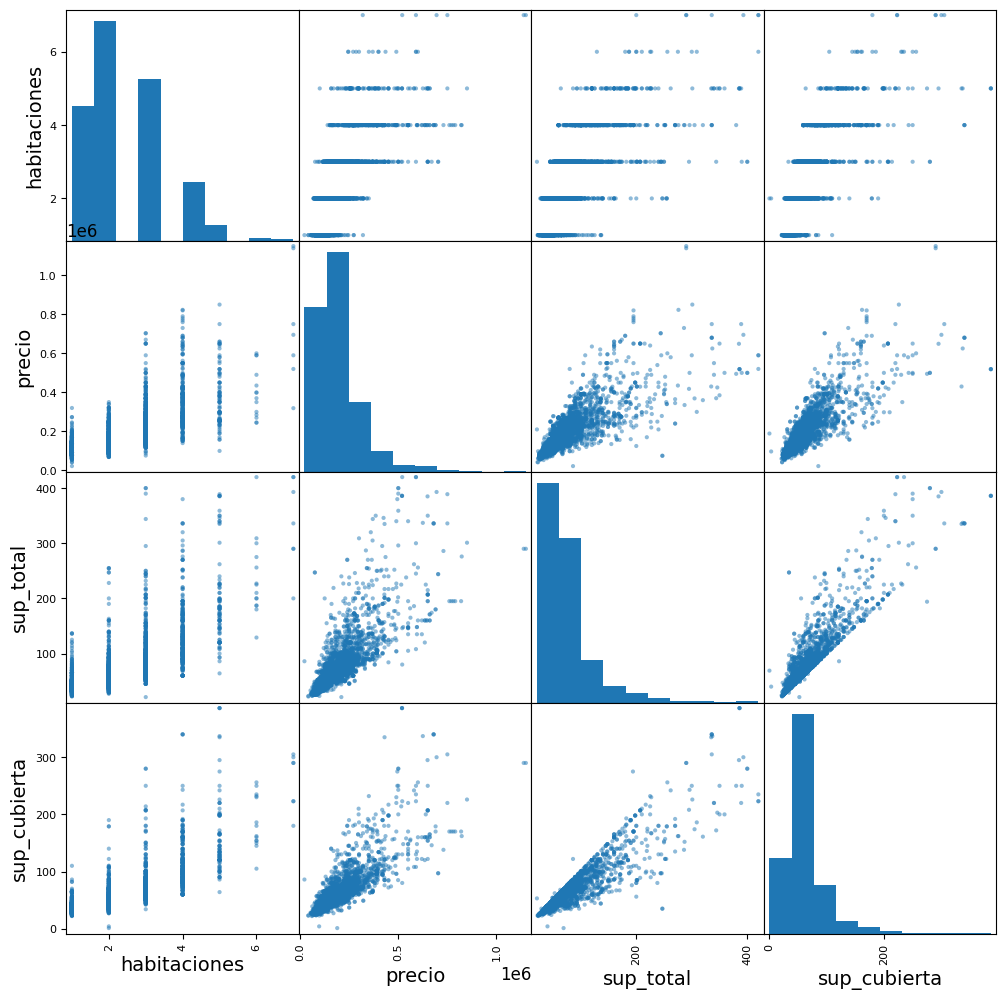

In [ ]:
pd.plotting.scatter_matrix(df_casas[['habitaciones', 'precio', 'sup_total','sup_cubierta']], figsize=(12, 12), alpha=0.5)

En particular, hoy **vamos a dejar atrás los modelos de una sola variable**, y vamos a tratar de predecir el precio de las viviendas a partir de la superficie total, la superficie cubierta y el número de habitaciones. Esto implica que ya **no vamos a poder graficar el modelo para poder visualizar qué tan bien ajusta a nuestros datos, y vamos a tener que valernos en cambio de las métricas que estuvimos viendo hasta ahora**. Vamos a seguir trabajando con los mismos modelos de la semana pasada.

## ¿Cómo elegir los hiperparámetros? Idea:

Hasta este punto se ha tomado un polinomio de cierto grado, pero ¿como sabemos si es óptimo?

Podemos usar el _test set_ para saber cual es el grado óptimo *M* y el parámetro de regularización $\lambda$.

* Elegir algún método de regularización.
* Hacer un bucle sobre todos los hiperparámetros y evaluar performance en _test set_.
* Reportar la mejor métrica (MSE).

**Pregunta importante**: Creen que este valor será representativo para estimar la performance en datos no vistos?

Comencemos con la usual separación entre conjuntos de entrenamiento y testeo:

In [ ]:
# Separa Train y Test
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test = train_test_split(df_casas[['sup_total','sup_cubierta','habitaciones']], df_casas['precio'], random_state=42)

## Implementación

Definamos una función para construir la regresión de _Ridge_. En este caso va a ser recomendable usar el StandardScaler para estandarizar nuestros datos, pues tienen unidades distintas no comparables.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import Ridge

def ridge(m, ll):
    """
    Construye un pipeline para la regresión contraída (ridge regression)
    usamos un StandardScaler

    :param int m: grado del polinomio de las características
    :param float ll: coeficiente de regularización lambda

    Atención: la función ridge toma como argumento alpha = lambda/2
    """
    return Pipeline([('scaler', StandardScaler()),
                     ('poly_features', PolynomialFeatures(degree=m)),
                     ('regressor', Ridge(alpha=ll/2))])

Ahora pasemos sobre todos los $M$ (grados) y $\lambda$ (valor del regularizador), y evaluemos en el conjunto:

In [ ]:
from sklearn.metrics import mean_squared_error

# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

# En esta lista voy a ir guardando los MSE en el conjunto de test
errores_test = []

# Iteramos sobre todos los valores y los guardamos todos
# Esto es principalmente porque nos interesa en esta etapa entender el espacio de hiperparámetros
# En algunos casos, por tema de memoria y/o performance, es interesante solo mantener los mejores-k
for ll in lambdas:
    for m in grados:
        # Creo modelo
        rr = ridge(m, ll)
        # Lo ajusto al conjunto de entrenamiento
        rr.fit(x_train, t_train)

        # Calculamos el MSE en test y lo agregamos a la lista de errores
        errores = mean_squared_error(t_test, rr.predict(x_test))
        errores_test.append(errores)

# Redimensiono los errores en una matriz (para después visualizarlos)
errores_test = np.array(errores_test).reshape((len(lambdas), len(grados)))
errores_test

array([[3.17477053e+09, 2.76446245e+09, 2.83876667e+09, 2.80331754e+09,
        3.38162992e+09, 6.48784314e+09],
       [3.17468319e+09, 2.76476769e+09, 2.83806045e+09, 2.78710087e+09,
        2.92841057e+09, 6.06554947e+09],
       [3.17384533e+09, 2.76788810e+09, 2.83296224e+09, 2.75704297e+09,
        2.74092891e+09, 4.43185983e+09],
       [3.16817585e+09, 2.80135432e+09, 2.81227165e+09, 2.77128233e+09,
        2.74286855e+09, 3.35407923e+09],
       [3.18465387e+09, 3.08643500e+09, 2.93691428e+09, 3.03110556e+09,
        3.03264862e+09, 3.09462330e+09]])

Los MSE están en las unidades (al cuadrado) de los precios de las viviendas (miles de dólares), así que para visualizarlos nos combiene tomarles la raíz cuadrada, y dividir por 1000:

In [ ]:
# Tomo raiz cuadrada del MSE y divido por 1000 para expresar el error en miles de dólares
errores_test_milusd = np.sqrt(errores_test)/1000
errores_test_milusd

array([[56.34510206, 52.5781556 , 53.28007764, 52.94636471, 58.15178349,
        80.54714858],
       [56.34432709, 52.58105824, 53.27344978, 52.79300018, 54.11479064,
        77.8816376 ],
       [56.33689134, 52.6107223 , 53.22557881, 52.50755152, 52.35388153,
        66.57221518],
       [56.28655125, 52.92782182, 53.03085566, 52.64297038, 52.37240259,
        57.914413  ],
       [56.43273757, 55.55569278, 54.19330474, 55.05547709, 55.06948898,
        55.62933849]])

Hagamos una gráfica del MSE como función de $M$ y $\lambda$ como una imagen. Aquí usamos la función `plt.pcolor`.

Text(0, 0.5, 'Regularizador ($\\lambda$)')

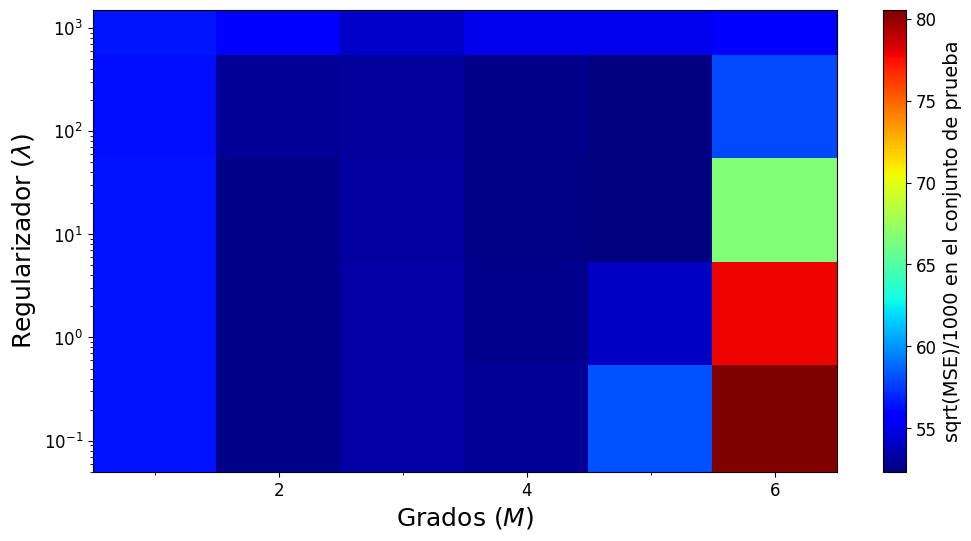

In [ ]:
# Valores de los ejes
Xp, Yp = np.meshgrid(grados, lambdas)
Zp = errores_test_milusd

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
# Grafico
pcol = plt.pcolor(Xp, Yp, Zp, cmap='jet')

# Usamos escala logarítmica para lambda
ax.set_yscale('log')
ax.set_ylim(0.05,1500)

# Define las marcas del eje x en números enteros
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Barra de colores y rótulos
plt.colorbar(pcol, label='sqrt(MSE)/1000 en el conjunto de prueba')
ax.set_xlabel('Grados ($M$)', fontsize=18)
ax.set_ylabel('Regularizador ($\lambda$)', fontsize=18)

Veamos cual es la posición del mínimo

In [ ]:
position = np.argmin(Zp)

mejor_grado = Xp.flatten()[position]
mejor_lambda = Yp.flatten()[position]
mejor_MSE = errores_test.flatten()[position]

print("M = {}".format(mejor_grado))
print("Lambda = {:.2e}".format(mejor_lambda))
print("MSE = {}".format(mejor_MSE))

M = 2
Lambda = 1.00e+02
MSE = 2801354322.7265525


¡Hemos encontrado la _mejor_ combinación de de $M$ y $\lambda$! ¿O hicimos algo mal?

Consideremos algunas **preguntas**:

* ¿Qué MSE esperamos en **datos nunca vistos**? ¿No estaremos en cierta manera sobreajustando a los datos de testeo?
* ¿Cambiará nuestro resultado si alteramos el corte de train/test?
* ¿Cuántos hiperparámetros distintos probamos?
***

# Validación

## Dataset apartado de validación

Para poder objetivamente asegurarnos la performance de nuestro modelo (sobre todo en el caso en que no conocemos la distribución real) en  **datos nuevos nunca vistos** debemos limitarnos y no mirar el conjunto de test. De otra manera sobreajustaremos al conjunto de test y no nos servirá como estimador de la performance real.

<iframe src="https://drive.google.com/file/d/105X0vd9VVfgGaeOT3a0VzZ2FT_7OSErq/preview" width="840" height="480" allow="autoplay"></iframe>

Por otro lado para buscar mejores hiperparámetros (parámetros que generalicen mejor a datos _no-vistos_) debemos hacerlo sobre puntos fuera del entrenamiento. Una solución sería mantener un conjunto para _entrenar_ otro para _validar_ hiperparámetros. Y otro más para tener un valor no sesgado de la performance de nuestro modelo.

A veces el conjunto de *entrenamiento* + *validación* se denomina conjunto de *desarrollo*.

El corte final sería así

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png" width=600/>

(*Km121220, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons*)

* Conjunto de Entrenamiento/Train: donde ajustamos el modelo.
* Conjunto de Validación: Donde evaluamos el modelo y lo usamos para escoger mejores hiperparámetros/características etc.
* Conjunto de Prueba/Test: Lo usamos solamente **al final** del desarrollo para establecer la performance esperada del modelo en datos nuevos.

Podemos implementar esto fácilmente en nuestro ejemplo usando dos veces consecutivas el `train_test_split()`:

In [ ]:
#Corte de train test y validación

# Primero separamos el test
from sklearn.model_selection import train_test_split
x_train_full, x_test, t_train_full, t_test = train_test_split(df_casas[['sup_total','sup_cubierta','habitaciones']], df_casas['precio'], random_state=42)

# Segundo, separamos el conjunto de validación
x_train, x_val, t_train, t_val = train_test_split(x_train_full, t_train_full, random_state=42)

Corremos las mismas rondas que antes pero ahora evaluando en validación.

In [ ]:
# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

# En esta lista voy a ir guardando los MSE
errores_validacion = []

for ll in lambdas:
    for m in grados:
        # Creo modelo
        rr = ridge(m, ll)
        # Lo ajusto al conjunto de entrenamiento
        rr.fit(x_train, t_train)

        # Calculamos el MSE en validacion y lo agregamos a la lista de errores
        errores = mean_squared_error(t_val, rr.predict(x_val))
        errores_validacion.append(errores)

# Redimensiono los errores en una matriz (para después visualizarlos)
errores_validacion = np.array(errores_validacion).reshape((len(lambdas), len(grados)))
errores_validacion

array([[4.02157694e+09, 3.84189029e+09, 4.07185362e+09, 3.56439731e+09,
        4.39262734e+09, 2.24617449e+11],
       [4.02043566e+09, 3.84239738e+09, 4.06042045e+09, 3.57793681e+09,
        4.22298904e+09, 1.77308967e+11],
       [4.00951948e+09, 3.84742022e+09, 3.98979994e+09, 3.60252025e+09,
        3.81670365e+09, 1.11124134e+11],
       [3.93574851e+09, 3.89630534e+09, 3.88435951e+09, 3.56356091e+09,
        3.85608837e+09, 3.56826894e+10],
       [3.89392327e+09, 4.31744500e+09, 4.11696280e+09, 3.87104507e+09,
        5.50464045e+09, 1.07489835e+10]])

Ahora podemos elegir los mejores hipérparametros usando la performance en set de validación.

In [ ]:
position = np.argmin(errores_validacion)

mejor_grado_val = grados[position%len(grados)]
mejor_lambda_val = lambdas[position//len(lambdas)]
mejor_MES_val = errores_validacion.flatten()[position]

print("Grado (M) = {}".format(mejor_grado_val))
print("Lambda = {:.2e}".format(mejor_lambda_val))
print("MSE = {:.2f}".format(mejor_MES_val))

Grado (M) = 4
Lambda = 1.00e+03
MSE = 3563560911.50


Y ahora usamos el dataset de test para ver la generalización a datos nuevos. Vamos a usar los hiperparámetros que acabamos de determinar con la validación:

In [ ]:
# Primero instanciamos el modelo
mejor_ridge_val = ridge(mejor_grado_val, mejor_lambda_val)

# Luego entrenamos
mejor_ridge_val.fit(x_train, t_train)

Y evaluamos el MSE en el conjunto de testeo

In [ ]:
y_test = mejor_ridge_val.predict(x_test)
print('Error de TEST final: {:.2f}'.format(mean_squared_error(t_test, y_test)))

Error de TEST final: 3123046365.10


Después de haber encontrado los _mejores_ hiperparámetros, se puede hacer un modelo final entrenando con toda la data.


In [ ]:
mejor_ridge_val = ridge(mejor_grado_val, mejor_lambda_val)
mejor_ridge_val.fit(x_train_full, t_train_full)

y_test = mejor_ridge_val.predict(x_test)
MSE_mejor_val = mean_squared_error(t_test, y_test)
print('Error de TEST final: {:.2f}'.format(MSE_mejor_val))

Error de TEST final: 3031105557.65


**Preguntas y ejercicios**

* ¿Qué percances hay en este procedimiento?

* ¿Cómo funcionaría mejor este método? ¿Con datasets grandes o chicos?

* Otra posibilidad sería tomar los k-mejores hiperparámetros, ya que hay varios hiperparámetros cerca del mínimo. Pero lamentablemente no sabemos cuánto score podemos estar perdiendo hasta ahora al hacer esto.

* Esto no nos sirve para identificar fluctuaciones aleatorias en la métrica. Es decir cuando ciertos hipérpametros tienen la suerte de ser mejores en validación pero no en el caso general. ¿Qué podemos hacer para estimar esto?

## Validación cruzada con K-Folding

Para resolver el problema anterior usamos _Validación Cruzada_. Consiste en entrenar sobre distintos cortes de entrenamiento y validación. De esta manera conseguimos una muestra de la distribución de performance de los hiperparámetros de distintos datasets. Entonces, podemos computar la varianza y la media de la performance, y elegir así el mejor hiperparámetro

¡Importante! La validación cruzada debe cumplir:
* Cada modelo debe ser entrenado en un corte particular de entrenamiento/validación (Lo llamaremos un _Fold_), para que sean lo más independiente posibles.
* Los datasets de validación deben tener intersección nula. Es decir no tener datos en común. De esta forma evitamos la posibilidad de tener correlaciones espurias entre las métricas y sobreajustar a un conjunto particular de puntos.

La forma más utilizada de hacer esto es _K-Fold Cross-Validation_, o validación cruzada con k cortes. Consiste en dividir el conjunto de desarrollo en K conjuntos e iterativamente usar K-1 para entrenar y el restante para validar. Luego de haber iterado sobre todos los cortes tendremos k mediciones distintas de la performance. Al elegir conjuntos con intersección nula (sin elementos en común) nos aseguramos que cada medición está descorrelacionada.


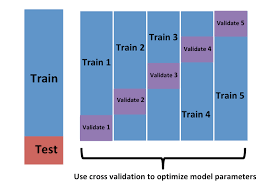

Esta técnica ya está implementada en `sklearn`. Definimos el número de Folds (cortes)  $K$ con el argumento `cv=`, y el score a usar con  `scoring=`.

**NOTA:**  mientras que *error* es un valor para el cual  *menos es mejor* el *score* tiene el comportamiento opuesto: *cuanto más, mejor*. Por esto definimos `neg_mean_squared_error` que corresponde al valor negativo del error.

**Pensemos:**
* Revisemos mejor `cross_val_score` .
* ¿Cuál es la forma de los `scores`?
* ¿Cómo estimamos el MSE a partir de los `scores`?
* Compare  con los resultados anteriores de validación y test. Admás obsere los valores individuales se `scores`. ¿Qué ve?

* Pista: ¿Qué dataset hay que pasar a `cross_val_score`. (`x,t`)`_train`? o (`x,t`)`_train_full`?

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score?

In [ ]:
model = ridge(mejor_grado_val, mejor_lambda_val)

scores = cross_val_score(model, x_train_full, t_train_full, cv=5, scoring='neg_mean_squared_error')
-scores

array([3.87054074e+09, 3.47842098e+09, 1.66584377e+10, 3.32561743e+09,
       3.48995447e+09])

In [ ]:
print(-scores.mean())
print(scores.std())

6164594257.352698
5249998960.736719


Veamos ahora qué ocurre cuando hacemos una búsqueda en todo el espacio.

In [ ]:
# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

cv_errors = []
cv_std = []

for ll in lambdas:
    for m in grados:
        # Crea el modelo

        rr = ridge(m, ll)

        scores = cross_val_score(rr, x_train_full, t_train_full, cv=5, scoring='neg_mean_squared_error')

        cv_errors.append(-scores.mean())
        cv_std.append(scores.std())

cv_errors = np.array(cv_errors).reshape((len(lambdas), len(grados)))
cv_std = np.array(cv_std).reshape((len(lambdas), len(grados)))

In [ ]:
errores_cv_milusd

Text(0, 0.5, 'Regularizador ($\\lambda$)')

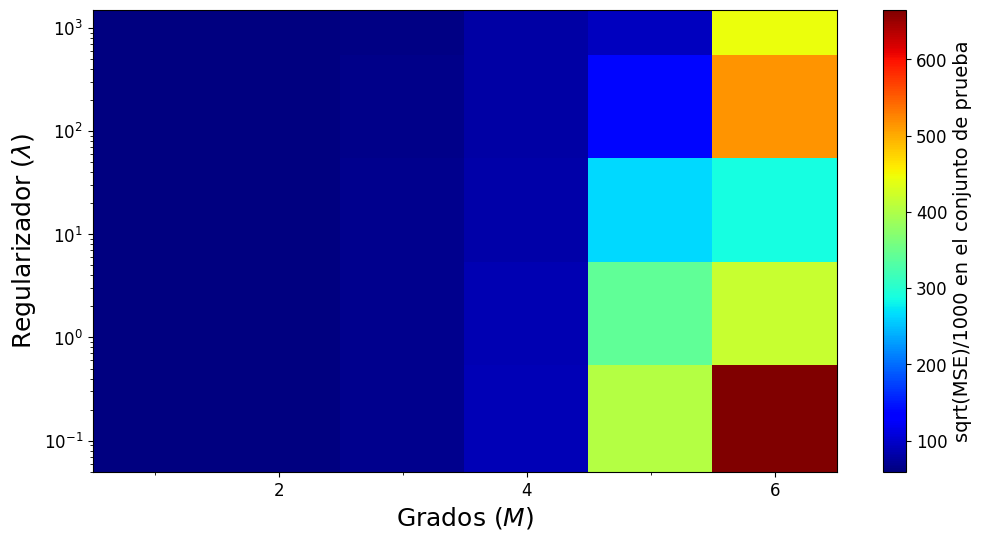

In [ ]:
# Valores de los ejes
Xp, Yp = np.meshgrid(grados, lambdas)
errores_cv_milusd = np.sqrt(cv_errors)/1000 # Expreso el errores en miles de usd
Zp = errores_cv_milusd

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
# Grafico
pcol = plt.pcolor(Xp, Yp, Zp, cmap='jet')

# Usamos escala logarítmica para lambda
ax.set_yscale('log')
ax.set_ylim(0.05,1500)

# Define las marcas del eje x en números enteros
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Barra de colores y rótulos
plt.colorbar(pcol, label='sqrt(MSE)/1000 en el conjunto de prueba')
ax.set_xlabel('Grados ($M$)', fontsize=18)
ax.set_ylabel('Regularizador ($\lambda$)', fontsize=18)

In [ ]:
position = np.argmin(cv_errors)

mejor_grado_cv = grados[position%len(grados)]
mejor_lambda_cv = lambdas[position//len(lambdas)]
MES_cv = cv_errors.flatten()[position]

print("Grado (M) = {}".format(mejor_grado_cv))
print("Lambda = {:.2e}".format(mejor_lambda_cv))
print("MSE = {:.2f}".format(MES_cv))
print("Std(MSE) = {:.2f}".format(cv_std.flatten()[position]))

Grado (M) = 2
Lambda = 1.00e+02
MSE = 3502413207.93
Std(MSE) = 483931448.68


In [ ]:
mejor_ridge_cv = ridge(mejor_grado_cv, mejor_lambda_cv)
mejor_ridge_cv.fit(x_train_full, t_train_full)

y_test = mejor_ridge_cv.predict(x_test)
MSE_mejor_cv = mean_squared_error(t_test, y_test)
print('Error final TEST: {:.2f}'.format(MSE_mejor_cv))

Error final TEST: 2801354322.73


# Exploración automática del espacio de búsqueda

Elegir los mejores hiperparámetros es una etapa corriente en el desarrollo de un modelo. En general para esto se usan modelos de "caja-negra" pero existen meta-modelos que también se pueden usar aunque implican cierto trabajo de adaptación a cada modelo. Las formas básicas de hacer esto usando sklearn son:
* `GridSearchCV`: El espacio de búsqueda se define con un diccionario de {hiper-parametro : valores}. Automáticamente genera una grilla con esos valores y pasa por todas las combinaciones.
* `RandomizedSearchCV:` Esta función recibe los mismos inputs que el caso anterior. Pero selecciona que combinaciones probar de manera aleatoria. No barre una por una. Tiene un parámetro `n_iter` que debemos fijar para que el modelo sepa cuándo debe dejar de probar puntos.

Veamos:

**Nota:** para acceder a los parámetros de cada paso o  _step_ en un pipeline, pueden acceder de la manera siguiente: `NombreDelPaso__NombreDelParametro` ( notar el doble `_` entre nombres). Si queremos ver el grado de PolynomialFeatures en el paso `poly_features`, debe escribir `poly_features__degree` en el diccionario de configuración.

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

model = Pipeline([('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures()),
    ('regressor', Ridge(fit_intercept=False) )
])

# Definimos los parámetros para cada parte del pipeline. Separamos parámetro de nombre con  ‘__’:
parameters = {'polynomial__degree' : range(1, 10),
              'regressor__alpha': np.logspace(-2, 4, 100)}


grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

Ahora corremos `fit` para saber cuáles son los mejore hiperparámetros.

In [ ]:
grid_search.fit(x_train_full, t_train_full)

Los mejores hiperparámetros son:

In [ ]:
grid_search.best_params_

{'polynomial__degree': 2, 'regressor__alpha': 24.770763559917114}

El score (-MSE) es

In [ ]:
grid_search.best_score_

-3512057632.4784327

Si queremos podemos recuperar toda la información de la optimización

In [ ]:
grid_search.cv_results_

Si queremos, por ejemplo podemos guardar los resultados del GridSearch en un DataFrame usando los diccionario que entrega el `grid_search.cv_results_`

In [ ]:
cv_results = grid_search.cv_results_

In [ ]:
# Armo el dataframe
results_df = pd.DataFrame(cv_results)

# Selecciono solo las columnas que me interesan
columnas = ['param_polynomial__degree', 'param_regressor__alpha',
            'mean_test_score', 'std_test_score']
results_df = results_df[columnas]

In [ ]:
results_df.head()

,param_polynomial__degree,param_regressor__alpha,mean_test_score,std_test_score
0,1,0.1,-3.597086e+09,3.723414e+08
1,1,0.183298,-3.597082e+09,3.723502e+08
2,1,0.335982,-3.597075e+09,3.723663e+08
3,1,0.615848,-3.597062e+09,3.723957e+08
4,1,1.128838,-3.597044e+09,3.724493e+08


EL mejor estimador se puede recuperar directamente aquí

In [ ]:
best_pr = grid_search.best_estimator_

In [ ]:
best_pr

## * RandomizedSearchCV

Cuando el espacio de búsqueda es muy grande es mejor recorrer sólo algunos puntos del espacio. `RandomizedSearchCV` nos permite hacer esto pasando el valores en todo el rango de nuestros parámetros. Automáticamente tomara puntos de prueba aleatorios en cada paso. También podemos pasarles distribuciones de los parámetros. Como siempre, ¡exploren la documentación!

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression

polinomial_model = Pipeline([('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('regressor', Ridge(fit_intercept=False) )
])

# los parámetros se setean por nombre y parametro con ‘__’ :
parameters = {'poly_features__degree' : np.arange(1,20),
              # observé que usamos funciones de scipy para definir el espacio de búsqueda
              'regressor__alpha' : np.logspace(-2, 8, 100)}

random_search = RandomizedSearchCV(polinomial_model, parameters, n_iter=40, random_state=42, scoring='neg_mean_squared_error', cv=5)

In [ ]:
random_search.fit(x_train_full, t_train_full)
random_search.best_params_, -random_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.21108e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


({'regressor__alpha': 34.30469286314919, 'poly_features__degree': 2},
 3515452973.805387)